<a href="https://colab.research.google.com/github/ThousandAI/Application-of-AI/blob/main/class05/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Resnet From Scratch**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters 
num_epochs = 10
batch_size = 64
learning_rate = 1e-4 #0.0001

### Cifar10

In [4]:
transform = transforms.Compose(
    [ transforms.Resize([224,224]),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
iterator = iter(train_loader)
images,labels = next(iterator)
print(images.shape, labels.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [6]:
def show(img):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  return np.transpose(npimg, (1, 2, 0))

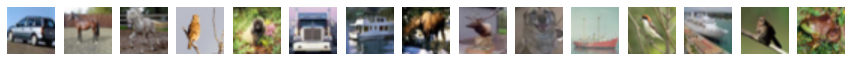

In [7]:
fig, axes = plt.subplots(1,15, figsize=(15, 15))
for i in range(15):
  axes[i].imshow(show(images[i]))
  axes[i].set_axis_off()
fig.show()

### Resnet From Scratch

In [8]:
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
      super(block, self).__init__()
      self.expansion = 4
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1,bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
      self.relu = nn.ReLU()
      self.identity_downsample = identity_downsample
      self.stride = stride

  def forward(self, x):
      identity = x.clone()
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.bn3(x)

      if self.identity_downsample is not None:
          identity = self.identity_downsample(identity)

      x += identity
      x = self.relu(x)
      return x

In [9]:
class ResNet(nn.Module):
  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # Essentially the entire ResNet architecture are in these 4 lines below
    self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
    self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
    self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
    self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512 * 4, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)

    return x

  def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
    identity_downsample = None
    layers = []

    # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
    # we need to adapt the Identity (skip connection) so it will be able to be added
    # to the layer that's ahead
    if stride != 1 or self.in_channels != intermediate_channels * 4:
        identity_downsample = nn.Sequential(
            nn.Conv2d(
                self.in_channels,
                intermediate_channels * 4,
                kernel_size=1,
                stride=stride,
                bias=False
            ),
            nn.BatchNorm2d(intermediate_channels * 4),
        )

    layers.append(
        block(self.in_channels, intermediate_channels, identity_downsample, stride)
    )

    # The expansion size is always 4 for ResNet 50,101,152
    self.in_channels = intermediate_channels * 4

    # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
    # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
    # and also same amount of channels.
    for i in range(num_residual_blocks - 1):
        layers.append(block(self.in_channels, intermediate_channels))

    return nn.Sequential(*layers)

In [10]:
resnet = ResNet(block, [3, 4, 6, 3], 3, 10)

In [11]:
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate)

In [12]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [13]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(resnet)

23528522

In [14]:
n_total_steps = len(train_loader)
for epoch in tqdm(range(num_epochs)):
  for i, (images, labels) in enumerate(train_loader):
    # origin shape: [64, 3, 224, 224]
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = resnet(images)
    loss = criterion(outputs, labels)
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Step [100/782], Loss: 1.8229
Epoch [1/10], Step [200/782], Loss: 1.6435
Epoch [1/10], Step [300/782], Loss: 1.4461
Epoch [1/10], Step [400/782], Loss: 1.6673
Epoch [1/10], Step [500/782], Loss: 1.2029
Epoch [1/10], Step [600/782], Loss: 1.2267
Epoch [1/10], Step [700/782], Loss: 1.1783


 10%|█         | 1/10 [05:38<50:50, 338.93s/it]

Epoch [2/10], Step [100/782], Loss: 1.1330
Epoch [2/10], Step [200/782], Loss: 0.9320
Epoch [2/10], Step [300/782], Loss: 0.9331
Epoch [2/10], Step [400/782], Loss: 1.0571
Epoch [2/10], Step [500/782], Loss: 0.5898
Epoch [2/10], Step [600/782], Loss: 0.7599
Epoch [2/10], Step [700/782], Loss: 0.8865


 20%|██        | 2/10 [11:10<44:34, 334.37s/it]

Epoch [3/10], Step [100/782], Loss: 0.8699
Epoch [3/10], Step [200/782], Loss: 0.7276
Epoch [3/10], Step [300/782], Loss: 0.5810
Epoch [3/10], Step [400/782], Loss: 0.6694
Epoch [3/10], Step [500/782], Loss: 0.9772
Epoch [3/10], Step [600/782], Loss: 0.7141
Epoch [3/10], Step [700/782], Loss: 0.5006


 30%|███       | 3/10 [16:41<38:50, 332.90s/it]

Epoch [4/10], Step [100/782], Loss: 0.3891
Epoch [4/10], Step [200/782], Loss: 0.2966
Epoch [4/10], Step [300/782], Loss: 0.6219
Epoch [4/10], Step [400/782], Loss: 0.6366
Epoch [4/10], Step [500/782], Loss: 0.4699
Epoch [4/10], Step [600/782], Loss: 0.6049
Epoch [4/10], Step [700/782], Loss: 0.5225


 40%|████      | 4/10 [22:11<33:10, 331.79s/it]

Epoch [5/10], Step [100/782], Loss: 0.2357
Epoch [5/10], Step [200/782], Loss: 0.5047
Epoch [5/10], Step [300/782], Loss: 0.3534
Epoch [5/10], Step [400/782], Loss: 0.2882
Epoch [5/10], Step [500/782], Loss: 0.2738
Epoch [5/10], Step [600/782], Loss: 0.4081
Epoch [5/10], Step [700/782], Loss: 0.4853


 50%|█████     | 5/10 [27:40<27:35, 331.01s/it]

Epoch [6/10], Step [100/782], Loss: 0.1610
Epoch [6/10], Step [200/782], Loss: 0.3688
Epoch [6/10], Step [300/782], Loss: 0.1791
Epoch [6/10], Step [400/782], Loss: 0.2954
Epoch [6/10], Step [500/782], Loss: 0.4097
Epoch [6/10], Step [600/782], Loss: 0.3475
Epoch [6/10], Step [700/782], Loss: 0.3506


 60%|██████    | 6/10 [33:10<22:01, 330.40s/it]

Epoch [7/10], Step [100/782], Loss: 0.2311
Epoch [7/10], Step [200/782], Loss: 0.2536
Epoch [7/10], Step [300/782], Loss: 0.0707
Epoch [7/10], Step [400/782], Loss: 0.1530
Epoch [7/10], Step [500/782], Loss: 0.1716
Epoch [7/10], Step [600/782], Loss: 0.1513
Epoch [7/10], Step [700/782], Loss: 0.3051


 70%|███████   | 7/10 [38:39<16:29, 329.95s/it]

Epoch [8/10], Step [100/782], Loss: 0.1087
Epoch [8/10], Step [200/782], Loss: 0.1082
Epoch [8/10], Step [300/782], Loss: 0.1367
Epoch [8/10], Step [400/782], Loss: 0.1470
Epoch [8/10], Step [500/782], Loss: 0.1976
Epoch [8/10], Step [600/782], Loss: 0.1377
Epoch [8/10], Step [700/782], Loss: 0.4341


 80%|████████  | 8/10 [44:08<10:59, 329.77s/it]

Epoch [9/10], Step [100/782], Loss: 0.0462
Epoch [9/10], Step [200/782], Loss: 0.1093
Epoch [9/10], Step [300/782], Loss: 0.0586
Epoch [9/10], Step [400/782], Loss: 0.1057
Epoch [9/10], Step [500/782], Loss: 0.1290
Epoch [9/10], Step [600/782], Loss: 0.2121
Epoch [9/10], Step [700/782], Loss: 0.1054


 90%|█████████ | 9/10 [49:37<05:29, 329.50s/it]

Epoch [10/10], Step [100/782], Loss: 0.0393
Epoch [10/10], Step [200/782], Loss: 0.0733
Epoch [10/10], Step [300/782], Loss: 0.0559
Epoch [10/10], Step [400/782], Loss: 0.1258
Epoch [10/10], Step [500/782], Loss: 0.0990
Epoch [10/10], Step [600/782], Loss: 0.1170
Epoch [10/10], Step [700/782], Loss: 0.2019


100%|██████████| 10/10 [55:06<00:00, 330.62s/it]


In [15]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = resnet(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 82.26 %
